# From Chapter 2
Note: I'm just copying the code from the book for reference later. I'm not super-satisfied with the author's Python style, even though it's probably still adherent to PEP8.

## Loading data
First we grab the data from GitHub and decompress it.

In [31]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

## Investigating the data
Here we're just loading it into a DataFrame and checking out the first couple of rows, followed by some information on the variables in the data.

In [32]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [33]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [34]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [35]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plot histograms of each of the numeric variables.

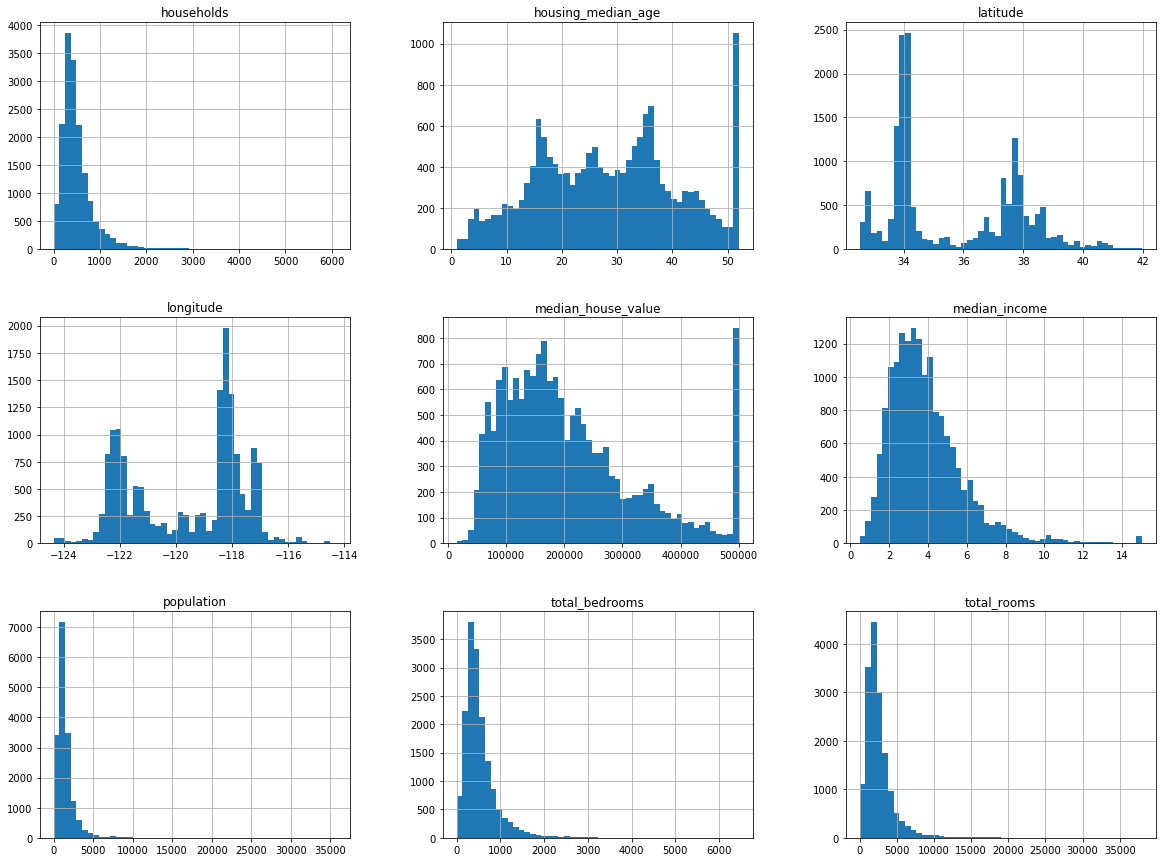

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Splitting Strategies
First up is a pretty basic NumPy strategy that may not be repeatable due to not setting the seed. We could include that though, by running something like the following before getting the random permutation.
```
np.random.seed(123)
```

In [37]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Next is a more robust & repeatable method where we first come up with a psuedo ID based on a record's MD5 hash, and then split based on the value of the hash's last byte. I don't know enough about the MD5 hashing algorithm to comment on whether or not this will actually yield a truly random split. It's possible that this splitting method is, or could be, determeninstic in some weird situations.

In [38]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

I'm also not happy with setting an ID on lon/lat. If this were participant or customer data, then the ID could possibly be considered uniquely identifying in a very extreme sense. For the data being used in this case, it's probably ok, but it's still using the hash split, so possibly not as random of a split as one might think.

In [39]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

This is the scikit-learn method of splitting the data, which the book says is pretty similar to the basic NumPy method, though thankfully more descriptive and terse.

In [40]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=123)

### Stratified Sampling
We'll break out the income from continuous values into discrete bins and then do some stratified sampling on that to make sure that we each strata is represented in the same quantities as the whole population.

In [41]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Here's a visual comparison of what this does to the variables by looking at the histograms:

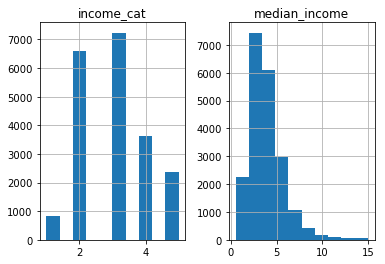

In [42]:
%matplotlib inline
housing[['median_income', 'income_cat']].hist()
plt.show()

Let's check the strata:

In [43]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Now we can do some stratified sampling using some scikit magick.

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

And then we can look at the income proportions in the training and test data. They should be pretty close to the proportions for the full sample.

In [45]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [46]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Seems legit.

In [47]:
pd.DataFrame({
    "housing": housing["income_cat"].value_counts() / len(housing),
    "strat_train_set": strat_train_set["income_cat"].value_counts() / len(strat_train_set),
    "strat_test_set": strat_test_set["income_cat"].value_counts() / len(strat_test_set)
})

,housing,strat_test_set,strat_train_set
3.0,0.350581,0.350533,0.350594
2.0,0.318847,0.318798,0.318859
4.0,0.176308,0.176357,0.176296
5.0,0.114438,0.114583,0.114402
1.0,0.039826,0.039729,0.039850


The book suggests that we need to take the `income_cat` variable out. Maybe that's an ok idea. It's probably not necessary though. Also, it may prove useful if we have a need to use income bins as a categorical variable.

In [48]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
# Replace housing with the training data to keep working on it.
housing = strat_train_set.copy()

## Visualizing Geographical Data
At this point I'm not going to actually get into using matplotlib's BaseMap package so that you can see that this California. But you can pretty much tell that's what it is...

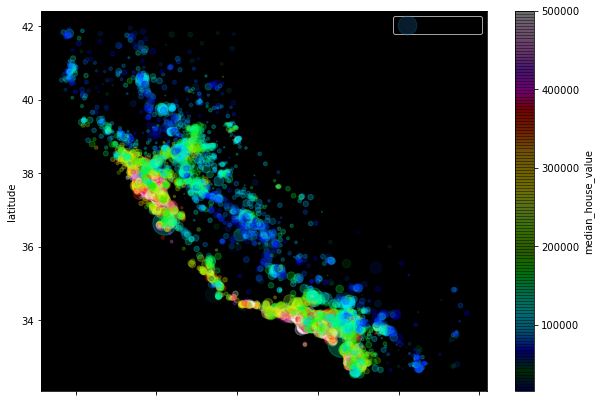

In [105]:
mpl.rcParams["axes.facecolor"] = "black"
housing.plot(kind="scatter",
             x="longitude",
             y="latitude",
             alpha=0.25,
             s=housing["population"]/50,
             label="population",
             figsize=(10,7),
             c="median_house_value",
             cmap=plt.get_cmap("gist_ncar"),
             colorbar=True)
plt.legend()

So, basically, house price appears correlated to ocean proximity and population density. Ie, subjective value and scarcity (supply/demand) drive prices. Who knew?